In [114]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go


In [115]:
PATH_TO_DATA = "./data/"

imu = pd.read_csv(PATH_TO_DATA + "imu_quadrat.csv", encoding="utf-16")
tab = pd.read_csv(PATH_TO_DATA + "tab_quadrat.csv", encoding="utf-8")

AZ_offset = 0.20095699862334726
AX_offset = 0.007442596491410214
AY_offset = -0.028499390421050208

tab = tab.drop([386, 3551]) # these values contain the header (string data)

tab[["x", "y", "z", "pressure"]] = tab[["x", "y", "z", "pressure"]].astype('float')
imu["ax"] = imu.ax - AX_offset
imu["ay"] = imu.ay - AY_offset
imu["az"] = imu.az - AZ_offset

# handling the host_timestamp values since they are too big 
tab["host_timestamp"] = tab["host_timestamp"].apply(lambda x: int(x[:-2]))
imu["host_timestamp"] = imu["host_timestamp"].apply(lambda x: x // 100)

In [116]:
imu.head(1)

,host_timestamp,arduino_timestamp,ax,ay,az,gx,gy,gz,temperature
0,226624125251,724265,-5.613843,5.942399,-5.173257,-0.0611,-0.1845,-0.0965,24.48


In [117]:
tab.head(1)

,host_timestamp,x,y,z,in_range,touch,pressure,reset
0,196472241368,-67.0,669.0,0.0,0,0,0.0,0


In [200]:
# merge data based on tablet data

t_left, t_right = tab["host_timestamp"].iloc[[0, -1]]
i_left, i_right = imu["host_timestamp"].iloc[[0, -1]]
left = max(t_left, i_left) #later start 
right = min(t_right, i_right) #earlier ending

# use tab data set as base to merge on
df = tab[(tab["host_timestamp"] >= left) & (tab["host_timestamp"] <= right)].copy()

#end_of_writing = df[df["pressure"]> 0.0].tail(1).index[0]
#df = df.iloc[:end_of_writing, :]

# Compute distance
#x = df["x"].values
#y = df["y"].values
#dx = np.diff(x, prepend=x[0])
#dy = np.diff(y, prepend=y[0])
#d = np.sqrt(dx ** 2 + dy ** 2)
#t = np.cumsum(d)
#length = t[-1]

data = pd.DataFrame()

# data is sampled with a  baud rate of 9600
length =  len(df) /100

# Sample at regular (spatial) interval
data["t_r"] = np.arange(0, length, 0.01)
print("The new length of the dataframe is {}".format(len(data["t_r"])))


The new length of the dataframe is 2895


In [201]:
# create time spans for interpolation
tab_time_span = np.linspace(np.min(df["host_timestamp"].values), np.max(df["host_timestamp"].values), len(data))
imu_time_span = np.linspace(np.min(imu["host_timestamp"].values), np.max(imu["host_timestamp"].values), len(data))

# interpolate tablet data
for column in ['x', 'y', 'z', 'pressure']:
    data[column] = np.interp(tab_time_span, df["host_timestamp"].values, df[column])

# interpolate imu data 
for column in ['ax', 'ay', 'az', 'gx', 'gy', 'gz']:
    data[column] = np.interp(imu_time_span, imu["host_timestamp"].values, imu[column])

In [202]:
data.head(2)

,t_r,x,y,z,pressure,ax,ay,az,gx,gy,gz
0,0.00,-212.0,814.0,0.0,0.0,-5.613843,5.942399,-5.173257,-0.061100,-0.184500,-0.096500
1,0.01,-212.0,814.0,0.0,0.0,-5.512561,5.927752,-4.882851,0.124735,-0.114365,-0.389995


In [203]:
def plot_trace(x,y,z,t):
    # Create the 3D scatter plot
    fig = go.Figure(data=go.Scatter3d(
        x=x_values,
        y=y_values,
        z=z_values,
        mode='markers',
        marker=dict(
            size=5,
            color=timestamps,
            colorscale='viridis',
            colorbar=dict(title='Time')
        )
    ))

    # Set plot title and axis labels
    fig.update_layout(
        title='Position Trace over Time',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        )
    )

    # Display the interactive plot
    fig.show()

# visualize data
x_values = data.x  
y_values = data.y 
timestamps = data.t_r 
z_values = data.z
plot_trace(x_values, y_values, z_values, timestamps)

In [204]:
# erase noisy data from beginning and end
data = data[data.index > 190] # 1000
data = data[data.index < 2600]

# visualize data
x_values = data.x  
y_values = data.y 
timestamps = data.t_r 
z_values = data.z
plot_trace(x_values, y_values, z_values, timestamps)

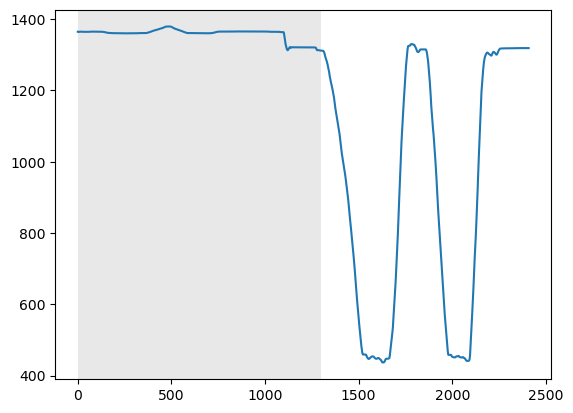

In [165]:
# seperate calibration data from drawing data)
def find_first_drop():
    indices = data.index.to_list()
    for i in range(10,len(indices)-31):
        curr = np.mean(data.loc[indices[i: i+30],"x"] )
        prev = np.mean(data.loc[indices[i-10: i-1],"x"])
        if curr * 1.05 < prev:
         return indices[i]
    return 0
fd = find_first_drop()
fd = 1300

# Color the background before the threshold x value
plt.axvspan(0, fd, facecolor='lightgrey', alpha=0.5)
plt.plot(range(len(data)), data.x)

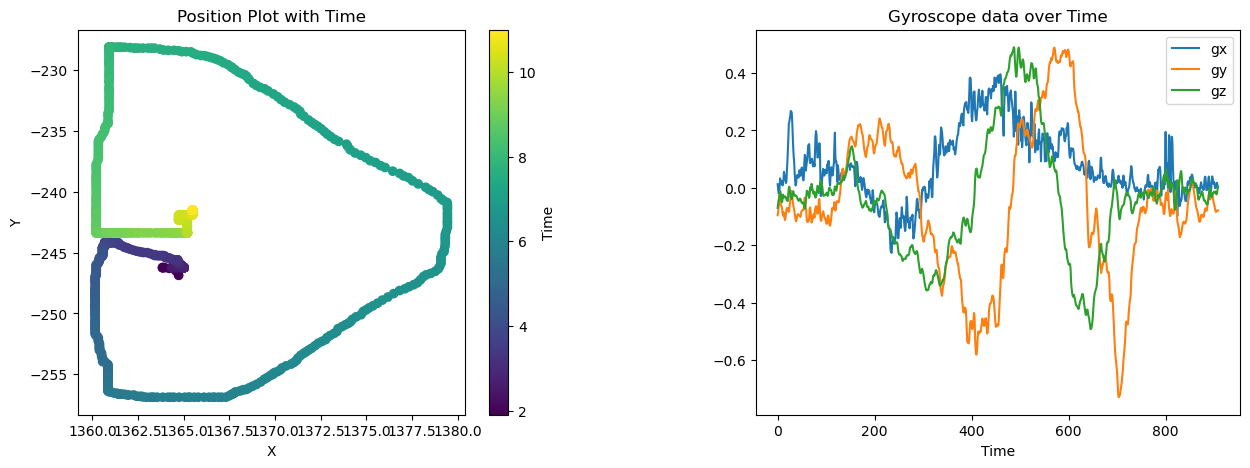

In [205]:
# plot calibration data
calibration_data = data[data.index < 1100] # hardcoded from plot
x_values = calibration_data.x  
y_values = calibration_data.y 
timestamps = calibration_data.t_r 
z_values = calibration_data.z
# Create the figure and axes for the subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot for x and y values with color-coded points
scatter = ax1.scatter(x_values, y_values, c=timestamps, cmap='viridis')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Position Plot with Time')
plt.colorbar(scatter, ax=ax1, label='Time')

# Plot for x values over time
ax2.plot(range(len(calibration_data)), calibration_data.gx, label = "gx")
ax2.plot(range(len(calibration_data)), calibration_data.gy, label = "gy")
ax2.plot(range(len(calibration_data)), calibration_data.gz, label = "gz")
ax2.set_xlabel('Time')
ax2.legend()
ax2.set_title('Gyroscope data over Time')

# Adjust spacing between the subplots
plt.subplots_adjust(wspace=0.4)

# Display the plot
plt.show()

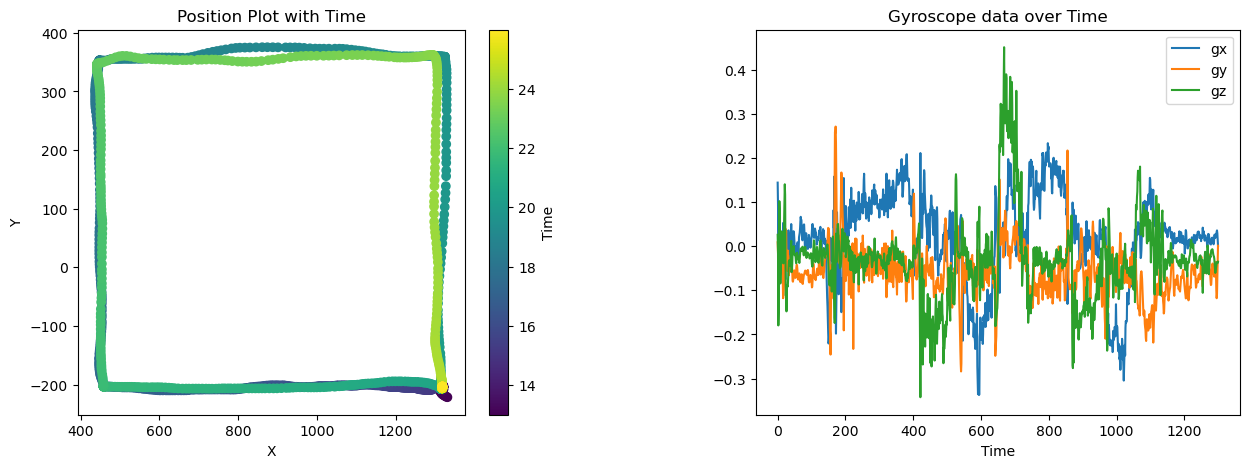

In [206]:
# plot rectangle data data
rectangle_data = data[data.index >= 1300] # hardcoded from plot
x_values = rectangle_data.x  
y_values = rectangle_data.y 
timestamps = rectangle_data.t_r 
z_values = rectangle_data.z
# Create the figure and axes for the subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot for x and y values with color-coded points
scatter = ax1.scatter(x_values, y_values, c=timestamps, cmap='viridis')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Position Plot with Time')
plt.colorbar(scatter, ax=ax1, label='Time')

# Plot for x values over time
ax2.plot(range(len(rectangle_data)), rectangle_data.gx, label = "gx")
ax2.plot(range(len(rectangle_data)), rectangle_data.gy, label = "gy")
ax2.plot(range(len(rectangle_data)), rectangle_data.gz, label = "gz")
ax2.set_xlabel('Time')
ax2.legend()
ax2.set_title('Gyroscope data over Time')

# Adjust spacing between the subplots
plt.subplots_adjust(wspace=0.4)

# Display the plot
plt.show()

In [207]:
from numpy.linalg import norm    
def rotation_matrix(q):
    # divide by norm so we have a unit quaternion
    q0 = q[0] / norm(q)
    q1 = q[1] / norm(q)
    q2 = q[2] / norm(q)
    q3 = q[3] / norm(q)

    R = np.zeros((3,3))
    
    R[0,0] = 1- 2 * (q2 * q2 + q3 * q3) 
    R[0,1] = 2 * (q1 * q2 - q0 * q3)
    R[0,2] = 2 * (q1 * q3 + q0 * q2)
    
    R[1,0] = 2 * (q1 * q2 + q0 * q3)
    R[1,1] = 1 - 2 * (q1 * q1 + q3 * q3) 
    R[1,2] = 2 * (q2 * q3 - q0 * q1)
    
    R[2,0] = 2 * (q1 * q3 - q0 * q2)
    R[2,1] = 2 * (q2 * q3 + q0 * q1)
    R[2,2] = 1 - 2 * (q1 * q1 + q2 * q2) 

    # inverse of R is body to global, matrix is orthogonal so transpose is equal to inverse                  
    return np.transpose(R)

In [182]:
import ahrs
from scipy.spatial.transform import Rotation

def calculate_position(acceleration, dt):
    velocity = np.zeros_like(acceleration)
    position = np.zeros_like(acceleration)

    for i in range(1, len(acceleration)):
        velocity[i] = velocity[i-1] + acceleration[i] * dt
        position[i] = position[i-1] + velocity[i] * dt

    return position

# Sample data
acceleration_sensor = rectangle_data[["ax", "ay", "az"]].to_numpy() 
gyroscope_sensor = rectangle_data[["gx", "gy", "gz"]].to_numpy()  
dt = 0.5  # Time interval between measurements

# Initialize the Madgwick filter
madgwick_filter = ahrs.filters.Madgwick()
madgwick_filter.Dt = dt

# Perform sensor fusion with Madgwick filter
orientation = np.tile(ahrs.common.orientation.acc2q(acceleration_sensor[0]), (len(gyroscope_sensor), 1))
for i in range(1, len(gyroscope_sensor)):
    orientation[i] = madgwick_filter.updateIMU(orientation[i-1],gyroscope_sensor[i], acceleration_sensor[i])


# Transform acceleration to the inertial frame using the estimated orientation
acceleration_inertial = np.zeros_like(acceleration_sensor)
for i in range(len(acceleration_sensor)):
    rotation = rotation_matrix(orientation[i])
    acceleration_inertial[i] = rotation @ acceleration_sensor[i]
    #rotation = Rotation.from_quat(orientation[i])
    #acceleration_inertial[i] = rotation.apply(acceleration_sensor[i])

# Calculate position using dead reckoning
position = calculate_position(acceleration_inertial, dt)
print(position)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.51653061e-01  2.29208483e+00  7.69119851e-01]
 [-5.71351962e-01  6.87581232e+00  2.22742703e+00]
 ...
 [ 2.32023778e+05  4.99963111e+05  4.62912334e+04]
 [ 2.32742881e+05  5.00243963e+05  4.64635807e+04]
 [ 2.33463659e+05  5.00526579e+05  4.66361890e+04]]


In [221]:
import ahrs
from sklearn.preprocessing import normalize


def calculate_position(acceleration, dt):
    velocity = np.zeros_like(acceleration)
    position = np.zeros_like(acceleration)

    for i in range(1, len(acceleration)):
        velocity[i] = velocity[i-1] + acceleration[i] * dt
        pos_1 = (0.4 * velocity[i-1] + 0.6 * acceleration[i] * dt) * dt
        pos_2 = position[i-1] + velocity[i] * dt
        position[i] = 0.3 * pos_1 + 0.7 * pos_2

    return position

def calculate_position1(acceleration, dt):
    window_size = 10
    velocity = np.zeros_like(acceleration)
    position = np.zeros_like(acceleration)
    position[0] = [10,10,0]

    for i in range(1, len(acceleration) -window_size + 1):
        velocity[i] = velocity[i-1] + np.mean(acceleration[i:i + window_size]) * dt
        pos_1 = (0.4 * velocity[i-1] + 0.6 * acceleration[i] * dt) * dt
        pos_2 = position[i-1] + velocity[i] * dt
        position[i] = 0.3 * pos_1 + 0.7 * pos_2

    return position

# Sample data
acceleration_sensor = rectangle_data[["ax", "ay", "az"]].to_numpy() 
gyroscope_sensor = rectangle_data[["gx", "gy", "gz"]].to_numpy()  
dt = 0.01  # Time interval between measurements

# Initialize the Mahony filter
# sample frequency is 100 Hz
mahony_filter = ahrs.filters.Mahony(k_P=1, ki=0.3, frequency=2)
mahony_filter.Dt = dt

gyro_bias_drift = np.array([-0.020441752719942672, 0.05859502084801568, 0.029742200995443946]) #np.array([-0.020441752719942672, 0.05859502084801568, 0.029742200995443946]) #np.array([0.04, 0.03, -0.07]) #[0.041,  0.031, - 0.0755]

# Perform sensor fusion with Madgwick filter
orientation = np.tile(ahrs.common.orientation.acc2q(acceleration_sensor[0]), (len(gyroscope_sensor), 1))
for i in range(1, len(gyroscope_sensor)):
    gyroscope_with_bias = gyroscope_sensor[i] + gyro_bias_drift * dt #* (1 / (i ** 100))
    orientation[i] = mahony_filter.updateIMU(orientation[i-1],gyroscope_with_bias, acceleration_sensor[i])


# Transform acceleration to the inertial frame using the estimated orientation
acceleration_inertial = np.zeros_like(acceleration_sensor)
for i in range(len(acceleration_sensor)):
    rotation = rotation_matrix(orientation[i])
    acc_i = (rotation @ acceleration_sensor[i]) - [0,0,1]
    acceleration_inertial[i]= (acc_i - np.min(acc_i)) / (np.max(acc_i) - np.min(acc_i))

# Calculate position using dead reckoning
position = calculate_position(acceleration_inertial, dt)
print(position)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.80000000e-05 2.63542584e-05]
 [0.00000000e+00 2.31600000e-04 7.10509030e-05]
 ...
 [6.09842171e-03 3.53895556e-01 3.85136713e-02]
 [6.09842171e-03 3.54168889e-01 3.85477598e-02]
 [6.09842171e-03 3.54442222e-01 3.85809268e-02]]


In [222]:
x_values = position[:,0] 
y_values = position[:,1] 
z_values = position[:,2] 
plot_trace(x_values, y_values, z_values, timestamps)

In [172]:
import ahrs

def calculate_position(acceleration, dt):
    velocity = np.zeros_like(acceleration)
    position = np.zeros_like(acceleration)

    for i in range(1, len(acceleration)):
        velocity[i] = velocity[i-1] + acceleration[i] * dt
        position[i] = position[i-1] + velocity[i] * dt

    return position

# Sample data
acceleration_sensor = rectangle_data[["ax", "ay", "az"]].to_numpy() 
gyroscope_sensor = rectangle_data[["gx", "gy", "gz"]].to_numpy()  
dt = 0.5  # Time interval between measurements

# Initialize the Mahony filter
# sample frequency is 100 Hz
mahony_filter = ahrs.filters.Mahony(k_P=1, ki=0.3, frequency=2)
mahony_filter.Dt = dt

gyro_bias_drift = np.array([0.04, 0.03, -0.07]) #np.array([-0.020441752719942672, 0.05859502084801568, 0.029742200995443946]) #np.array([0.04, 0.03, -0.07]) #[0.041,  0.031, - 0.0755]

# Perform sensor fusion with Madgwick filter
orientation = np.tile(ahrs.common.orientation.acc2q(acceleration_sensor[0]), (len(gyroscope_sensor), 1))
for i in range(1, len(gyroscope_sensor)):
    gyroscope_with_bias = gyroscope_sensor[i] + gyro_bias_drift * dt * (1 / (i ** 100))
    orientation[i] = mahony_filter.updateIMU(orientation[i-1],gyroscope_with_bias, acceleration_sensor[i])


# Transform acceleration to the inertial frame using the estimated orientation
acceleration_inertial = np.zeros_like(acceleration_sensor)
for i in range(len(acceleration_sensor)):
    rotation = rotation_matrix(orientation[i])
    acceleration_inertial[i] = (rotation @ acceleration_sensor[i]) 

# Calculate position using dead reckoning
position = calculate_position(acceleration_inertial, dt)
print(position)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.15704487e-01  2.29488452e+00  7.45099656e-01]
 [-7.68084997e-01  6.87914124e+00  2.15644099e+00]
 ...
 [ 2.36929622e+05  4.70874652e+05  7.83710719e+04]
 [ 2.37290866e+05  4.71701593e+05  7.86263549e+04]
 [ 2.37652138e+05  4.72530673e+05  7.88804479e+04]]


In [173]:
# tansform tablet pixel data to m 

tablet_width_mm = 216.0
tablet_height_mm = 135.0
tablet_lpi = 2540
display_dpi = 96

# Sample pixel coordinates
x_pixel = 100
y_pixel = 150

# Convert pixel coordinates to meters
x_m = (x_pixel / tablet_lpi) * (25.4 / display_dpi) * tablet_width_mm / 1000
y_m = (y_pixel / tablet_lpi) * (25.4 / display_dpi) * tablet_height_mm / 1000

In [178]:
# Sample data
acceleration_sensor = calibration_data[["ax", "ay", "az"]].to_numpy() 
gyroscope_sensor = calibration_data[["gx", "gy", "gz"]].to_numpy()  
dt = 0.5  # Time interval between measurements

# Initialize the Mahony filter
# sample frequency is 100 Hz
mahony_filter = ahrs.filters.Mahony(k_P=1, ki=0.3, frequency=2)
mahony_filter.Dt = dt

gyro_bias_drift = np.array([-0.020441752719942672, 0.05859502084801568, 0.029742200995443946])

# Perform sensor fusion with Madgwick filter
orientation = np.tile(ahrs.common.orientation.acc2q(acceleration_sensor[0]), (len(gyroscope_sensor), 1))
A = np.empty((len(gyroscope_sensor), 3, 3))
for i in range(1, len(gyroscope_sensor)):
    gyroscope_with_bias = gyroscope_sensor[i] + gyro_bias_drift * dt
    orientation[i] = mahony_filter.updateIMU(orientation[i-1],gyroscope_with_bias, acceleration_sensor[i])


# Transform acceleration to the inertial frame using the estimated orientation
acceleration_inertial = np.zeros_like(acceleration_sensor)
for i in range(len(acceleration_sensor)):
    rotation = rotation_matrix(orientation[i])
    A[i] = rotation - np.eye(3)
    acceleration_inertial[i] = (rotation @ acceleration_sensor[i])

# Calculate position using dead reckoning
position = calculate_position(acceleration_inertial, dt) 

In [179]:
A_flat = A.reshape(-1, 9)
# Solve the least squares problem
x, residuals, rank, singular_values = np.linalg.lstsq(A_flat, position, rcond=None)


I should probably remove this from the sensor

In [180]:
plot_trace(x[:,0], x[:,1], x[:,2], calibration_data.t_r)

## Static calibration


### Gyroscope data

In [ ]:
# mit kabel oberhalb flach auf dem tisch
calibration_z = pd.read_csv(PATH_TO_DATA + "imu_calibration-z.csv", encoding="utf-8")
# mit kabel nach oben in x pfeil richtung wie auf dem sensor
calibration_x = pd.read_csv(PATH_TO_DATA + "imu_calibration-x.csv", encoding="utf-8")
# kabel zu mir zeigend, sodass y pfeil auf dem sensor nach oben zeigt
calibration_y = pd.read_csv(PATH_TO_DATA + "imu_calibration-y.csv", encoding="utf-8")

In [ ]:
calibration_y.head(1)

,host_timestamp,arduino_timestamp,ax,ay,az,gx,gy,gz,temperature
0,400712643771900,2212671,-0.1555,9.7711,0.4319,0.0208,-0.0586,-0.0281,22.09


In [ ]:
gx_offset_z = np.mean(calibration_z.gx)
gy_offset_z = np.mean(calibration_z.gy)
gz_offset_z = np.mean(calibration_z.gz)

gx_offset_x = np.mean(calibration_x.gx)
gy_offset_x = np.mean(calibration_x.gy)
gz_offset_x = np.mean(calibration_x.gz)

gx_offset_y = np.mean(calibration_y.gx)
gy_offset_y = np.mean(calibration_y.gy)
gz_offset_y = np.mean(calibration_y.gz)

gx_offset = np.mean([gx_offset_z, gx_offset_x, gx_offset_y])
gy_offset = np.mean([gy_offset_z, gy_offset_x, gy_offset_y])
gz_offset = np.mean([gz_offset_z, gz_offset_x, gz_offset_y])

print("Gx mean: {}, the gy mean: {} and the gz mean {}".format(gx_offset, gy_offset, gz_offset))

Gx mean: 0.020441752719942672, the gy mean: -0.05859502084801568 and the gz mean -0.029742200995443946


In [ ]:
az_offset = np.mean(calibration_z.az) + 9.81
print("AZ offset" , az_offset)

ax_offset = np.mean(calibration_x.ax) + 9.81
print("AX offset" , ax_offset)

ax_offset = np.mean(calibration_y.ay) - 9.81
print("AY offset" , ax_offset)

AZ offset 0.20095699862334726
AX offset 0.007442596491410214
AY offset -0.028499390421050208
